<h1 style="text-align: center"> A Tale of Two cities</h1>
<h2 style="text-align: center">Clustering the Neighborhoods of London and Paris</h2>

<p style="text-align: center"> 4<sup>th</sup> April, 2021</p>

### 1. Introduction

A Tale of Two cities, a novel written by Charles Dickens was set in London and Paris which takes place during the French Revolution. Both these cities were a happening a happening place at that time as well as now. A lot has changed over the years and we now take a look at how the cities have grown.

London and Paris are quite the popular tourist and vacation destinations for people all around the world. They are diverse and multicultural and offer a wide variety of experiences that is widely sought after. We try to group the neighbourhoods of London and Paris respectively and draw insights to what they look like now.

### 2. Business Problem

The aim is to help tourists choose their destinations depending on the experiences that the neighbourhoods have to offer and what they would want to have. This also helps people make decisions if they are thinking about migrating to London or Paris or even if they want to relocate neighbourhoods within the city. Our findings will help stakeholders make informed decisions and address any concerns they have including the different kinds of cuisines, provision stores and what the city has to offer. 

### 3. Data Description

We require geographical location data for both London and Paris. Postal codes in each city serve as a starting point. Using Postal codes we use can find out the neighborhoods, boroughs, venues and their most popular venue categories

#### 3.1 London

To derive our solution, We scrape our data from https://en.wikipedia.org/wiki/List_of_areas_of_London

This wikipedia page has information about all the neighbourhoods, we limit it London.

*    borough : Name of Neighbourhood
*    town : Name of borough
*     post_code : Postal codes for London.

This wikipedia page lacks information about the geographical locations. To solve this problem we use ArcGIS API

#### 3.2 ArcGIS API

ArcGIS Online enables you to connect people, locations, and data using interactive maps. Work with smart, data-driven styles and intuitive analysis tools that deliver location intelligence. Share your insights with the world or specific groups.

More specifically, we use ArcGIS to get the geo locations of the neighbourhoods of London. The following columns are added to our initial dataset which prepares our data.

*    latitude : Latitude for Neighbourhood
*     longitude : Longitude for Neighbourhood

#### 3.3 Paris

To derive our solution, We leverage JSON data available at https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e

The JSON file has data about all the neighbourhoods in France, we limit it to Paris.

*    postal_code : Postal codes for France
*    nom_comm : Name of Neighbourhoods in France
*    nom_dept : Name of the boroughs, equivalent to towns in France
*    geo_point_2d : Tuple containing the latitude and longitude of the Neighbourhoods.

#### 3.4 Foursquare API Data



We will need data about different venues in different neighbourhoods of that specific borough. In order to gain that information we will use "Foursquare" locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighbourhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighbourhood. For each neighbourhood, we have chosen the radius to be 500 meters.

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

*    Neighbourhood : Name of the Neighbourhood
*    Neighbourhood Latitude : Latitude of the Neighbourhood
*    Neighbourhood Longitude : Longitude of the Neighbourhood
*    Venue : Name of the Venue
*    Venue Latitude : Latitude of Venue
*    Venue Longitude : Longitude of Venue
*    Venue Category : Category of Venue

Based on all the information collected for both London and Paris, we have sufficient data to build our model. We cluster the neighbourhoods together based on similar venue categories. We then present our observations and findings. Using this data, our stakeholders can take the necessary decision.

### 4. Methodology

We will be creating our model with the help of Python so we start off by importing all the required packages.

Package breakdown:

* Pandas : To collect and manipulate data in JSON and HTMl and then data analysis
* requests : Handle http requests
* matplotlib : Detailing the generated maps
* folium : Generating maps of London and Paris
* sklearn : To import Kmeans which is the machine learning model that we are using.

The approach taken here is to explore each of the cities individually, plot the map to show the neighbourhoods being considered and then build our model by clustering all of the similar neighbourhoods together and finally plot the new map with the clustered neighbourhoods. We draw insights and then compare and discuss our findings.

#### 4.1 Data Collection

In the data collection stage, we begin with collecting the required data for the cities of London and Paris. We need data that has the postal codes, neighbourhoods and boroughs specific to each of the cities.

To collect data for London, we scrape the List of areas of London wikipedia page to take the 2nd table using the following code:

```url_london = "https://en.wikipedia.org/wiki/List_of_areas_of_London" <br>
wiki_london_url = requests.get(url_london) <br>
wiki_london_data = pd.read_html(wiki_london_url.text) <br>
wiki_london_data = wiki_london_data[1] <br>
wiki_london_data <br>
```
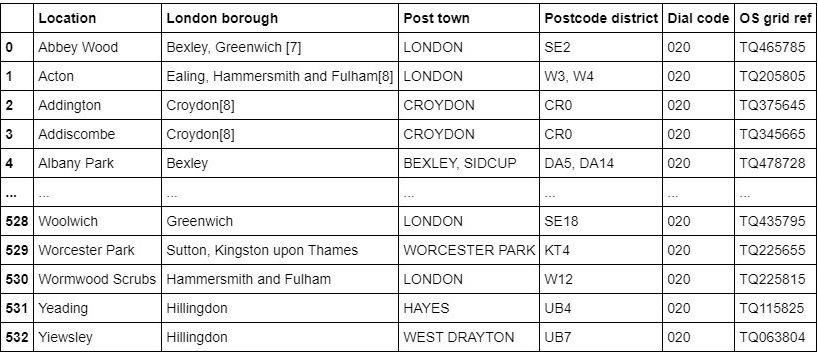

To collect data for Paris, we download the JSON file containg all the postal codes of France from https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e

Using Pandas we load the table after reading the JSON file:

```!wget -q -O 'france-data.json' https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e <br>
print("Data Downloaded!") <br>
paris_raw = pd.read_json('france-data.json') <br>
paris_raw.head() <br>
```
![Data%20Coll%202.jpg](attachment:Data%20Coll%202.jpg)

#### 4.2 Data Pre-processing

For London, We replace the spaces with underscores in the title.The borough column has numbers within square brackets that we remove using:

wiki_london_data.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True) <br>
wiki_london_data['borough'] = wiki_london_data['borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))For Paris, we break down each of the nested fields and create the dataframe that we need:

paris_field_data = pd.DataFrame() <br>
for f in paris_raw.fields: <br>
    dict_new = f <br>
    paris_field_data = paris_field_data.append(dict_new, ignore_index=True) <br>

paris_field_data.head()

#### 4.2 Feature Selection

For both of our datasets, we need only the borough, neighbourhood, postal codes and geolocations (latitude and longitude). So we end up selecting the columns that we need by:

df1 = wiki_london_data.drop( [ wiki_london_data.columns[0], wiki_london_data.columns[4], wiki_london_data.columns[5] ], axis=1) <br>
df_2 = paris_field_data[['postal_code','nom_comm','nom_dept','geo_point_2d']]

#### 4.4 Feature Engineering

Both of our Datasets actually contain information related to all the cities in the country. We can narrow down and further process the data by selecting only the neighbourhoods pertaining to 'London' and 'Paris'

df1 = df1[df1['town'].str.contains('LONDON')] <br>
df_paris = df_2[df_2['nom_dept'].str.contains('PARIS')].reset_index(drop=True)

Looking over our London dataset, we can see that we don't have the geolocation data. We need to extrapolate the missing data for our neighbourhoods. We perform this by leveraging the ArcGIS API. With the Help of ArcGIS API we can get the latitude and longitude of our London neighbourhood data.

from arcgis.geocoding import geocode <br>
from arcgis.gis import GIS <br>
gis = GIS() <br>
Defining London arcgis geocode function to return latitude and longitude <br>

def get_x_y_uk(address1): <br>
   lat_coords = 0 <br>
   lng_coords = 0 <br>
   g = geocode(address='{}, London, England, GBR'.format(address1))[0] <br>
   lng_coords = g['location']['x'] <br>
   lat_coords = g['location']['y'] <br>
   return str(lat_coords) +","+ str(lng_coords) <br>
Passing postal codes of london to get the geographical co-ordinates <br>

coordinates_latlng_uk = geo_coordinates_uk.apply(lambda x: get_x_y_uk(x)) <br>
We proceed with Merging our source data with the geographical co-ordinates to make our dataset ready for the next stage <br>

london_merged = pd.concat([df1,lat_uk.astype(float), lng_uk.astype(float)], axis=1) <br>
london_merged.columns= ['borough','town','post_code','latitude','longitude'] <br>
london_merged <br>

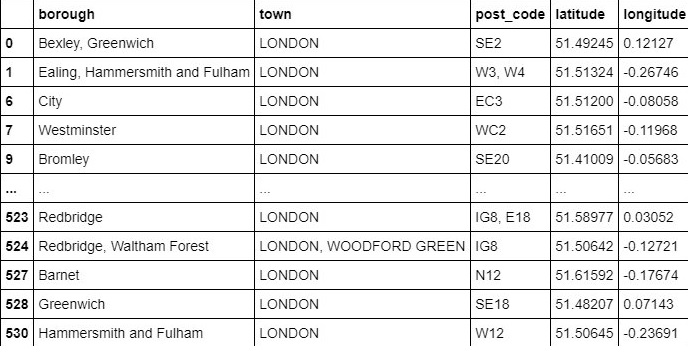

As for our Paris dataset, we don't need to get the geo coordinates using an external data source or collect it with the ArcGIS API call since we already have it stored in the geo_point_2d column as a tuple in the df_paris dataframe.

We just need to extract the latitude and longitude for the column:

paris_lat = paris_latlng.apply(lambda x: x.split(',')[0]) <br>
paris_lat = paris_lat.apply(lambda x: x.lstrip('[')) <br>

paris_lng = paris_latlng.apply(lambda x: x.split(',')[1]) <br>
paris_lng = paris_lng.apply(lambda x: x.rstrip(']')) <br>

paris_geo_lat  = pd.DataFrame(paris_lat.astype(float)) <br>
paris_geo_lat.columns=['Latitude'] <br>

paris_geo_lng = pd.DataFrame(paris_lng.astype(float)) <br>
paris_geo_lng.columns=['Longitude'] <br>
We then create our Paris dataset with the required information: <br>

paris_combined_data = pd.concat([df_paris.drop('geo_point_2d', axis=1), paris_geo_lat, paris_geo_lng], axis=1) <br>
paris_combined_data <br>

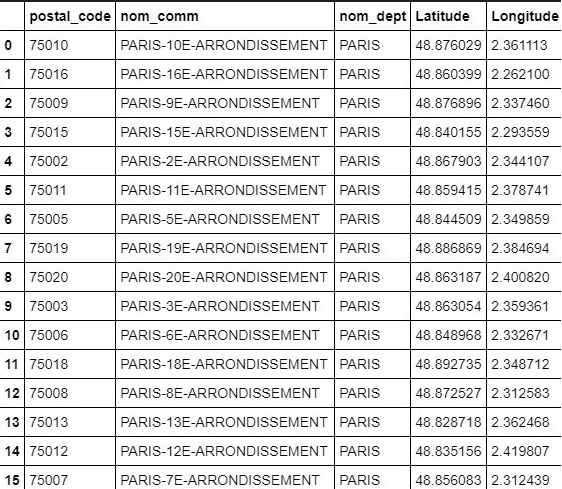

* <i> Note: Both the datasets have been properly processed and formatted. Since the same steps are applied to both the datasets of London and Paris, we will be discussing the code for only the London dataset for simplicity. </i>

#### 4.5 Visualizing the Neighbourhoods of London and Paris

Now that our datasets are ready, using the Folium package, we can visualize the maps of London and Paris with the neighbourhoods that we collected.<br>

Neighbourhood map of London:

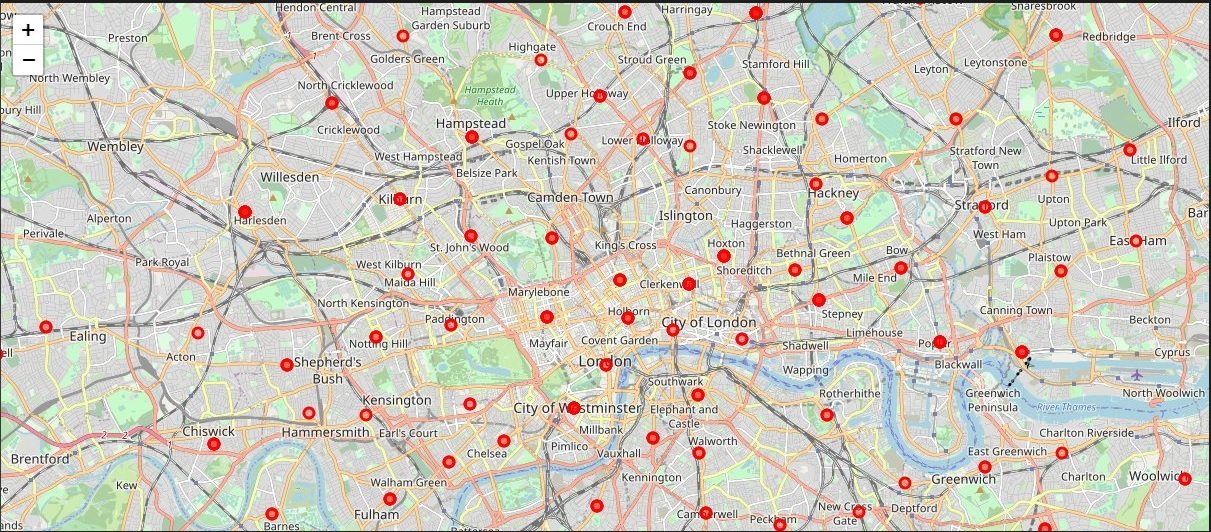

Neighbourhood map of Paris:

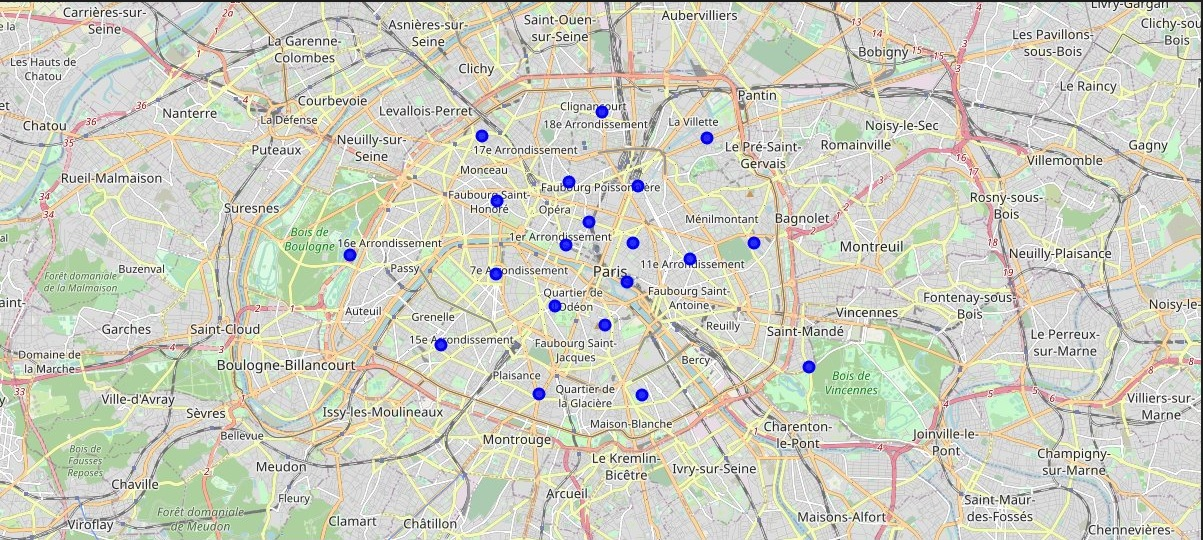

Now that we have visualized the neighbourhoods, we need to find out what each neighbourhood is like and what are the common venue and venue categories within a 500m radius.

This is where Foursquare comes into play. With the help of Foursquare we define a function which collects information pertaining to each neighbourhood including that of the name of the neighbourhood, geo-coordinates, venue and venue categories.

LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)
Resulting data looks like:
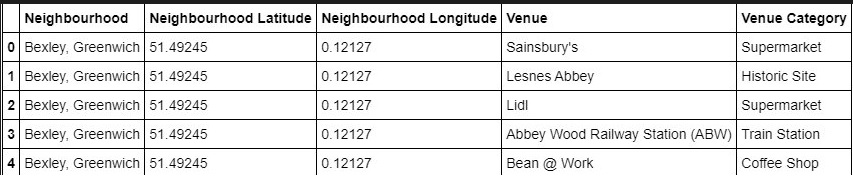

#### 4.6 One Hot Encoding

Since we are trying to find out what are the different kinds of venue categories present in each neighbourhood and then calculate the top 10 common venues to base our similarity on, we use the One Hot Encoding to work with our categorical datatype of the venue categories. This helps to convert the categorical data into numeric data.

We won't be using label encoding in this situation since label encoding might cause our machine learning model to have a bias or a sort of ranking which we are trying to avoid by using One Hot Encoding.

We perform one hot encoding and then calculate the mean of the grouped venue categories for each of the neighbourhoods.

###### One hot encoding
London_venue_cat = pd.get_dummies(venues_in_London[['Venue Category']], prefix="", prefix_sep="")

###### Adding neighbourhood to the mix
London_venue_cat['Neighbourhood'] = venues_in_London['Neighbourhood'] 

###### Moving neighborhood column to the first column
fixed_columns = [London_venue_cat.columns[-1]] + list(London_venue_cat.columns[:-1])
London_venue_cat = London_venue_cat[fixed_columns]

###### Grouping and calculating the mean
London_grouped = London_venue_cat.groupby('Neighbourhood').mean().reset_index()

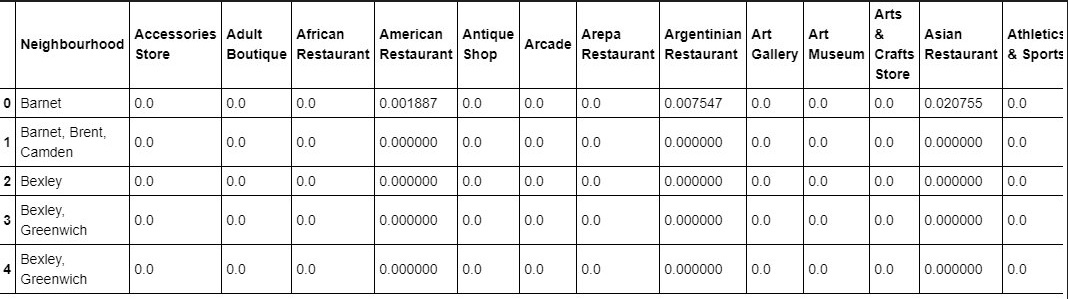

#### 4.7 Top Venues in the Neighbourhoods

In our next step, We need to rank and label the top venue categories in our neighborhood.

Let's define a function to get the top venue categories in the neighbourhood

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
There are many categories, we will consider top 10 categories to avoid data skew.

Defining a function to label them accurately

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

##### Create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
Getting the top venue categories in the neighbourhoods of London

##### Create a new dataframe for London
neighborhoods_venues_sorted_london = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_london['Neighbourhood'] = London_grouped['Neighbourhood']

for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted_london.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_london.head()

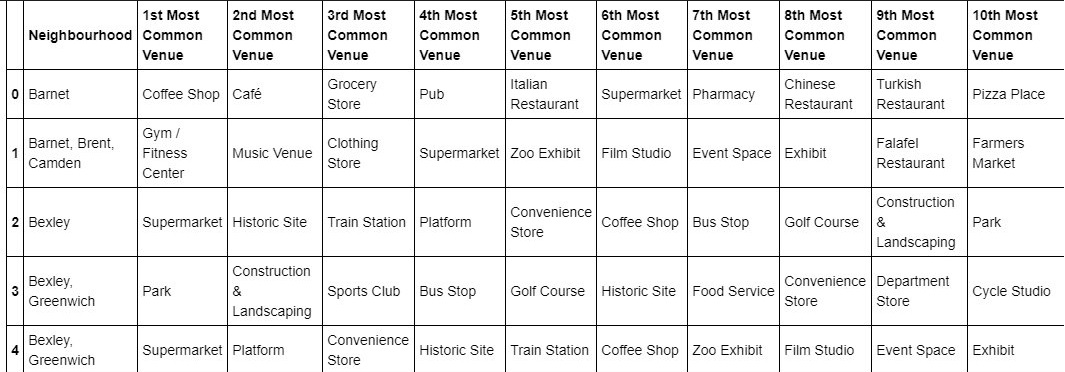

#### 4.8 Model Building - KMeans

Moving on to the most exicitng part - Model Building! We will be using KMeans Clustering Machine learning algorithm to cluster similar neighbourhoods together. We will be going with the number of clusters as 5.

##### Set number of clusters
k_num_clusters = 5

London_grouped_clustering = London_grouped.drop('Neighbourhood', 1)

##### Run k-means clustering
kmeans_london = KMeans(n_clusters=k_num_clusters, random_state=0).fit(London_grouped_clustering)
Our model has labelled each of the neighbourhoods, we add the label into our dataset.

neighborhoods_venues_sorted_london.insert(0, 'Cluster Labels', kmeans_london.labels_ +1)
We then join London_merged with our neighbourhood venues sorted to add latitude & longitude for each of the neighborhood to prepare it for visualization.

london_data = london_merged

london_data = london_data.join(neighborhoods_venues_sorted_london.set_index('Neighbourhood'), on='borough')

london_data.head()

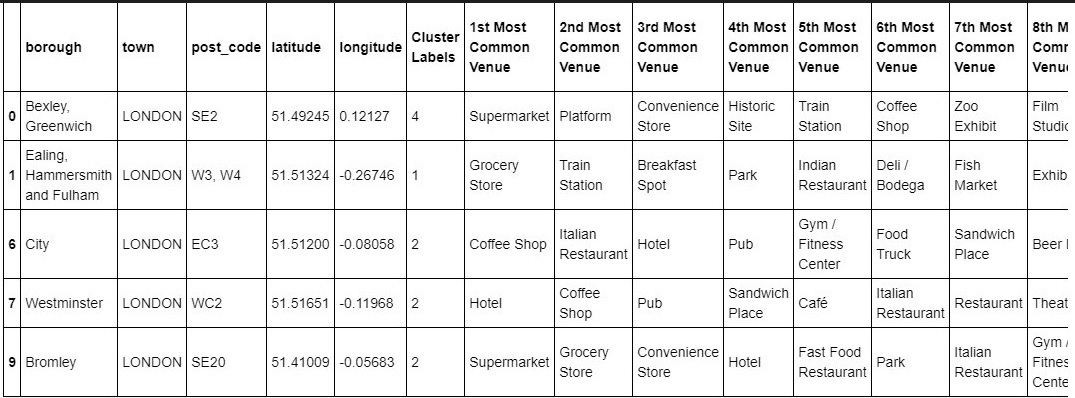

#### 4.9 Visualizing the clustered Neighbourhoods

Our data is processed, missing data is collected and compiled. The Model is built. All that's remaining is to see the clustered neighbourhoods on the map. Again, we use Folium package to do so.

We drop all the NaN values to prevent data skew

london_data_nonan = london_data.dropna(subset=['Cluster Labels']) <br><br>
Map of clustered neighbourhoods of London:
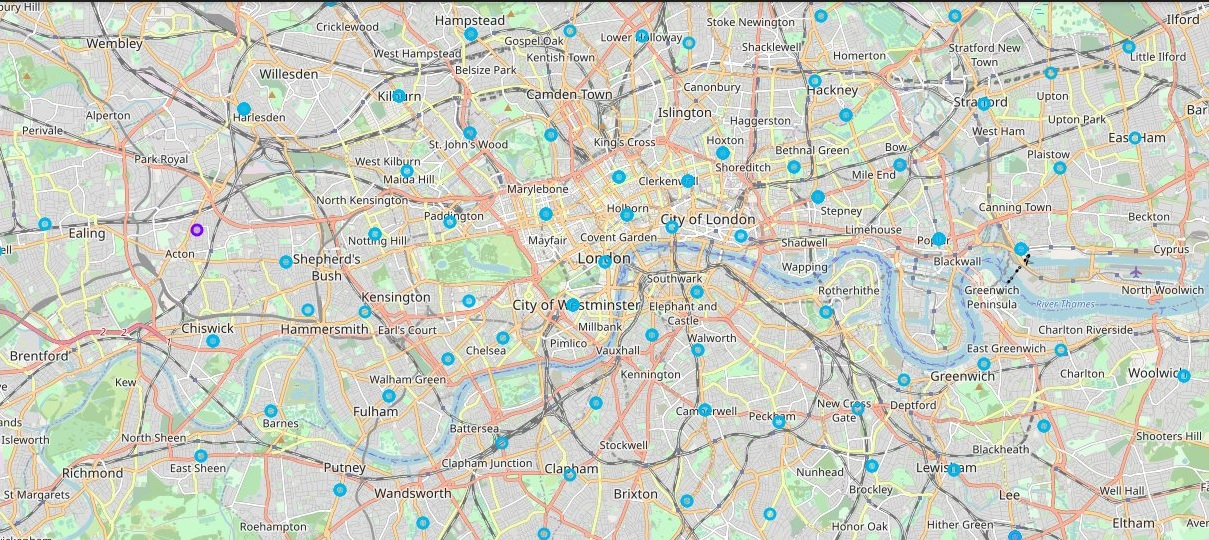

Map of clustered neighbourhoods of Paris:
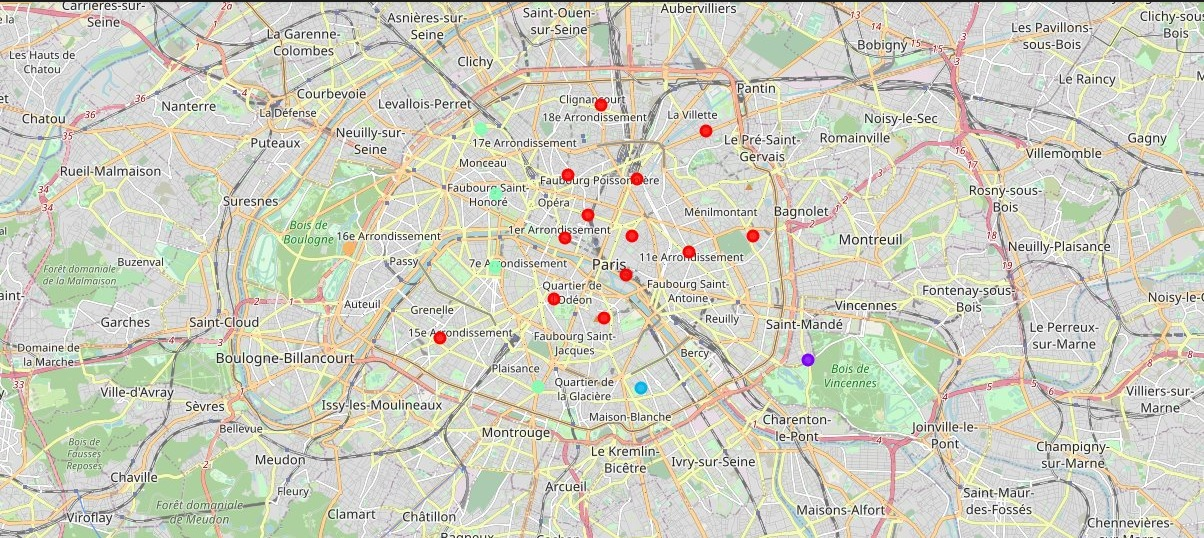

###### 4.9.1 Examining our Clusters
We could examine our clusters by expanding on our code using the Cluster Labels column:

Cluster 1 <br>
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 1, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]] <br>

Cluster 2 <br>
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 2, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]] <br>

Cluster 3 <br>
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 3, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]] <br>

Cluster 4 <br>
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 4, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]] <br>

Cluster 5 <br>
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 5, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]] <br>

### 5. Results and Discussion
The neighbourhoods of London are very mulitcultural. There are a lot of different cusines including Indian, Italian, Turkish and Chinese. London seems to take a step further in this direction by having a lot of Restaurants, bars, juice bars, coffee shops, Fish and Chips shop and Breakfast spots. It has a lot of shopping options too with that of the Flea markets, flower shops, fish markets, Fishing stores, clothing stores. The main modes of transport seem to be Buses and trains. For leisure, the neighbourhoods are set up to have lots of parks, golf courses, zoo, gyms and Historic sites. Overall, the city of London offers a multicultural, diverse and certainly an entertaining experience.

Paris is relatively small in size geographically. It has a wide variety of cusines and eateries including French, Thai, Cambodian, Asian, Chinese etc. There are a lot of hangout spots including many Restaurants and Bars. Paris has a lot of Bistro's. Different means of public transport in Paris which includes buses, bikes, boats or ferries. For leisure and sight seeing, there are a lot of Plazas, Trails, Parks, Historic sites, clothing shops, Art galleries and Museums. Overall, Paris seems like the relaxing vacation spot with a mix of lakes, historic spots and a wide variety of cusines to try out.

### 6. Conclusion

The purpose of this project was to explore the cities of London and Paris and see how attractive it is to potential tourists and migrants. We explored both the cities based on their postal codes and then extrapolated the common venues present in each of the neighbourhoods finally concluding with clustering similar neighbourhoods together.

We could see that each of the neighbourhoods in both the cities have a wide variety of experiences to offer which is unique in it's own way. The cultural diversity is quite evident which also gives the feeling of a sense of inclusion.

Both Paris and London seem to offer a vacation stay or a romantic getaway with a lot of places to explore, beautiful landscapes, amazing food and a wide variety of culture. Overall, it's upto the stakeholders to decide which experience they would prefer more and which would more to their liking.

<p style="text-align: right">- Tanuj Singh</p>
<p style="text-align: right">4<sup>th</sup>April, 2021</p>